In [9]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Change to use continuous adjoint method
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import experiments.helpers.plotting_linear as plt
import experiments.helpers.training as train

In [10]:
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

# Learning a linear system
This is a simple example to show how to use the `torchdiffeq` library to learn a linear system of ODEs. We'll explore two different models and compare the results. The first model is neural network with a hidden layer and a non-linear activation function (we'll try two of them). The second model is a simpler neural network with no hidden layers and no activation function. Basically, it is a linear model. This is to show that knowing the structure of the system can help us choose a simpler model that works better.

## Model 1: Can we approximate the vector field with a MLP?

In this section we try with two different neural networks, differing only in the activation function. The frist one uses a tanh activation function and the second one uses a ReLU activation function.

### Hyperparameters

In [11]:
args = {
    'method': 'dopri5',
    'data_size': 5000,
    'batch_time': 20,
    'batch_size': 2500,
    'niters': 100000,
    'test_freq': 1000,
    'terminal_time': 25.,
    'learning_rate': 1e-4,
    'eps': 1e-2,
    'tol': 1
}

### The data

The model needs data to train on. Let's create a linear system that will be used as the underlying system to learn. 

In [12]:
t = torch.linspace(0., args['terminal_time'], args['data_size'])


#### Define the real system
First define the real system, which is a linear system of ODEs with a known solution. Then calculate the solution of the system using the `odeint` function from `torchdiffeq` and plot the solution.

In [13]:
true_y0 = torch.tensor([[2., 0.]])
true_A = torch.tensor([[-0.1, 3.0], [-3.0, -0.1]])

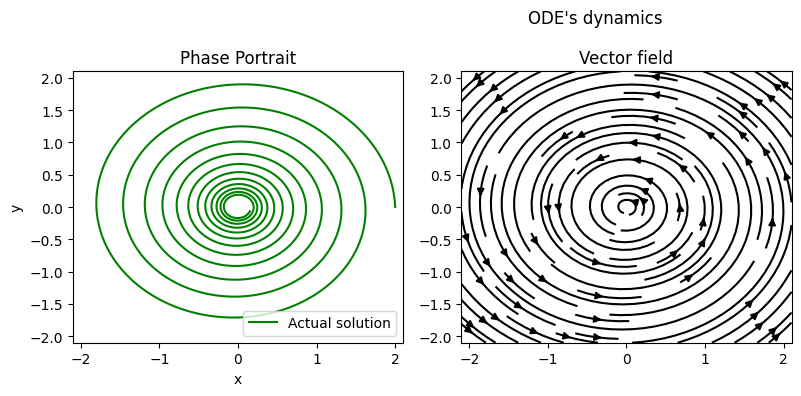

In [14]:
true_vector_field = lambda t, y: torch.mm(y, true_A)
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')
plt.plot_ode(true_y, true_vector_field)

### Testing different activation functions

### Tanh

In [15]:
# Define a Neural Network to learn the vector field
class ODEnnT(nn.Module):

    def __init__(self):
        super(ODEnnT, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODEnnT()

#### Train the neural network

In [16]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.train_model(func, optimizer, true_y0, true_y, t, args)

Iter 0000 | Total Loss 228.935303
Iter 1000 | Total Loss 94.475433
Iter 2000 | Total Loss 43.281754
Iter 3000 | Total Loss 18.974648
Iter 4000 | Total Loss 13.413229
Iter 5000 | Total Loss 10.511415
Iter 6000 | Total Loss 9.317338
Iter 7000 | Total Loss 8.170099
Iter 8000 | Total Loss 7.451206
Iter 9000 | Total Loss 6.448603
Iter 10000 | Total Loss 6.166566
Iter 11000 | Total Loss 5.552253
Iter 12000 | Total Loss 5.654423
Iter 13000 | Total Loss 5.174480
Iter 14000 | Total Loss 5.555130
Iter 15000 | Total Loss 5.421968
Iter 16000 | Total Loss 4.633000
Iter 17000 | Total Loss 4.798265
Iter 18000 | Total Loss 4.897871
Iter 19000 | Total Loss 4.287127
Iter 20000 | Total Loss 4.436267
Iter 21000 | Total Loss 3.775209
Iter 22000 | Total Loss 4.296508
Iter 23000 | Total Loss 4.102659
Iter 24000 | Total Loss 3.569232
Iter 25000 | Total Loss 3.573123
Iter 26000 | Total Loss 3.669909
Iter 27000 | Total Loss 3.975944
Iter 28000 | Total Loss 3.474715
Iter 29000 | Total Loss 3.884329
Iter 30000 | 

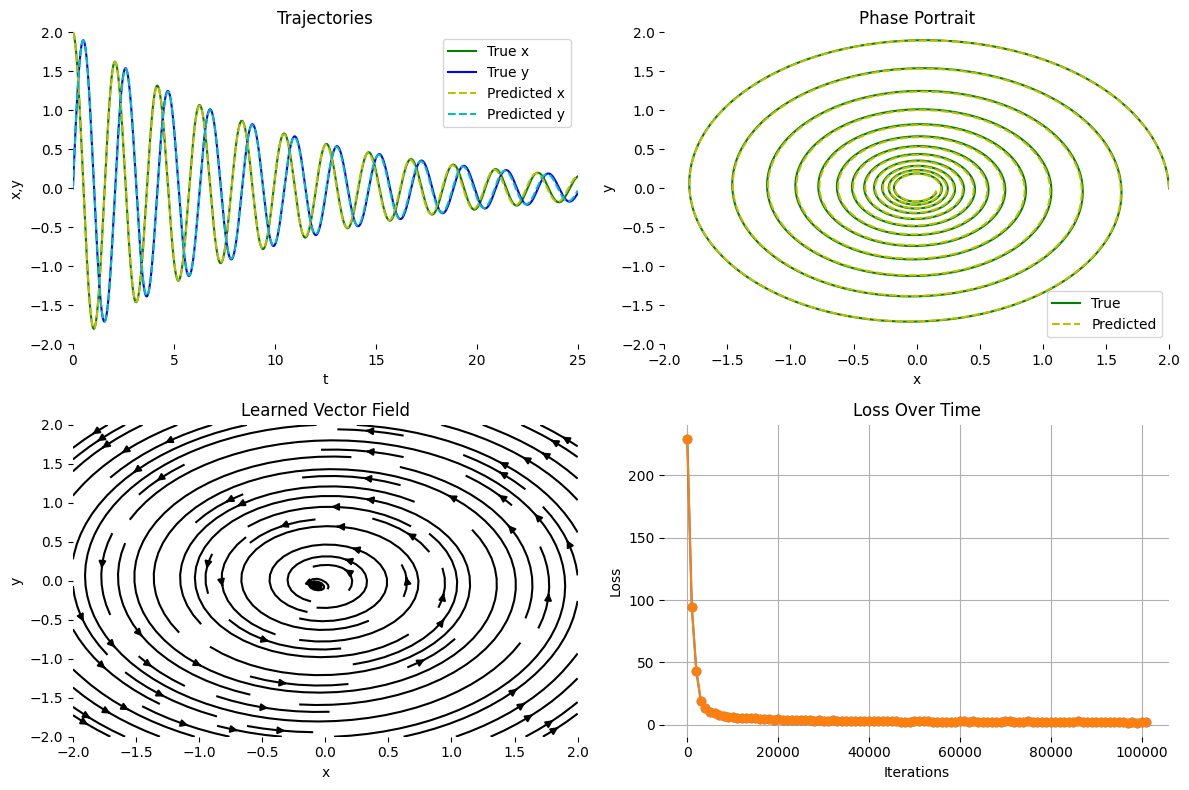

In [17]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [18]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method='dopri5')

Total Test Loss 1.496287


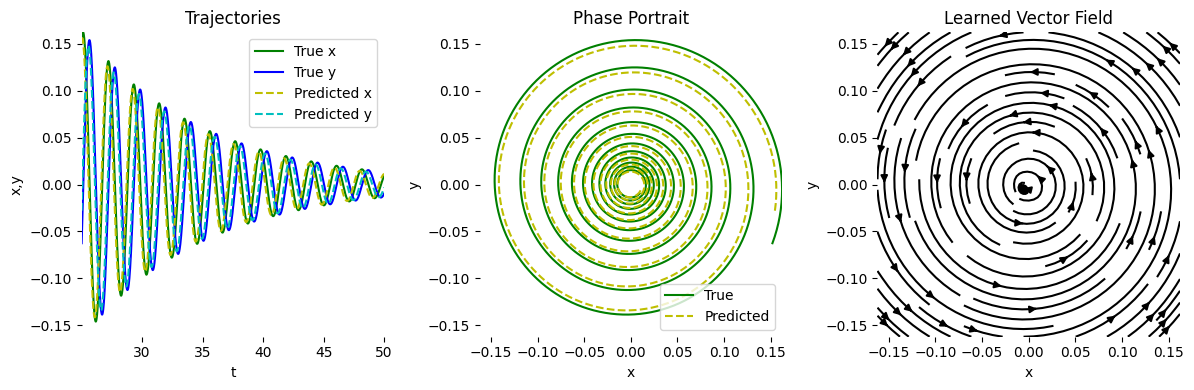

In [19]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. However, when looking at the graph one can appreciate the solution goes faster than the actual system.

Actually, it seems the model is not able to learn the vector trajectory of the solution with much precision after some time. 

#### Can the model train with a different initial condition?

In this section we define a different $y_0$ and train the model again.

In [20]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [21]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

Iter 0000 | Total Loss 459.724182
Iter 1000 | Total Loss 176.332642
Iter 2000 | Total Loss 153.749176
Iter 3000 | Total Loss 135.037018
Iter 4000 | Total Loss 122.222061
Iter 5000 | Total Loss 107.899376
Iter 6000 | Total Loss 98.809158
Iter 7000 | Total Loss 92.483788
Iter 8000 | Total Loss 81.697121
Iter 9000 | Total Loss 75.207565
Iter 10000 | Total Loss 71.612984
Iter 11000 | Total Loss 66.227821
Iter 12000 | Total Loss 59.148449
Iter 13000 | Total Loss 57.218094
Iter 14000 | Total Loss 58.849022
Iter 15000 | Total Loss 55.161594
Iter 16000 | Total Loss 53.114521
Iter 17000 | Total Loss 51.092403
Iter 18000 | Total Loss 43.169495
Iter 19000 | Total Loss 41.324490
Iter 20000 | Total Loss 39.189648
Iter 21000 | Total Loss 39.266842
Iter 22000 | Total Loss 30.349789
Iter 23000 | Total Loss 31.639914
Iter 24000 | Total Loss 30.879246
Iter 25000 | Total Loss 26.204882
Iter 26000 | Total Loss 29.866329
Iter 27000 | Total Loss 27.048973
Iter 28000 | Total Loss 30.818007
Iter 29000 | Total

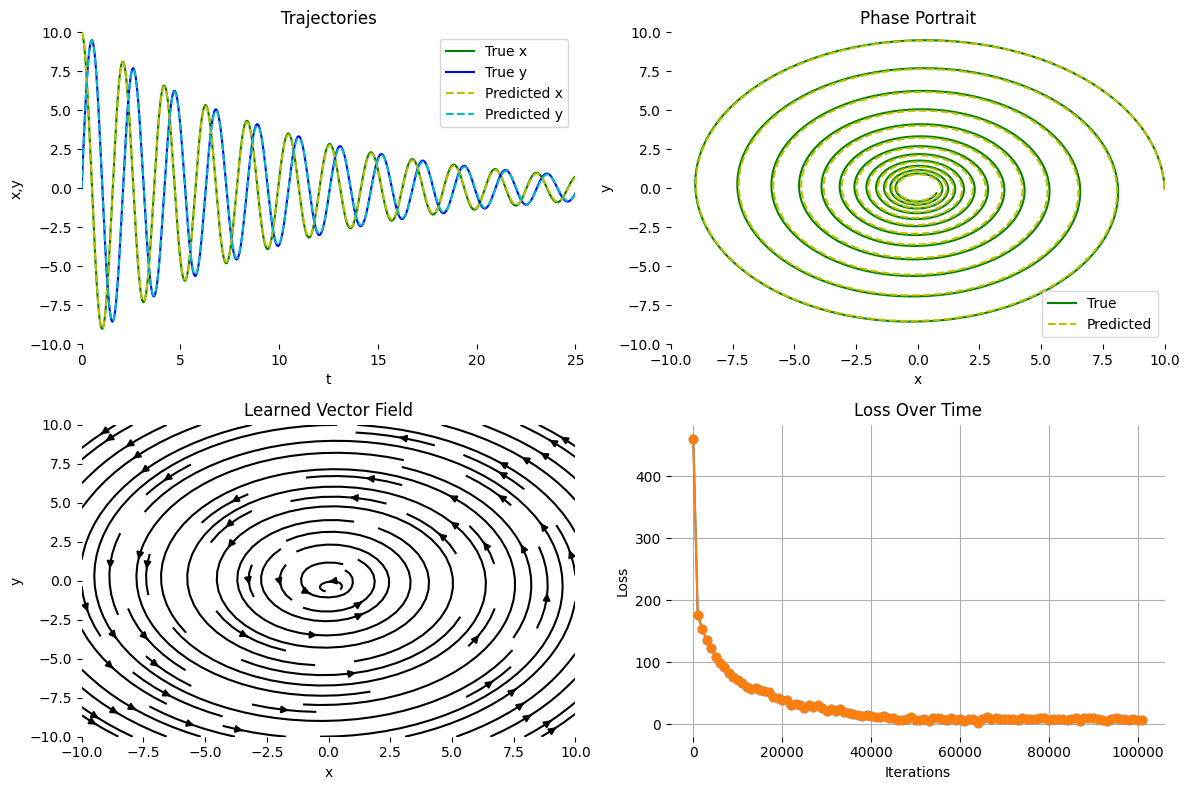

In [22]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=args['method']), t, func, new_losses, args['test_freq'])

This generalisation has a much higher error than the previous one. This is because the vector field has much larger values in the vicinity of the new initial condition. Not only does this cause the error, in general, to be much larger, but it also makes the system more sensitive to small discrepancies in the predicted points, which add up to a large error. However, when looking at the graph the solution seems to fit rather well. 

### ReLU

In [23]:
# Define a Neural Network to learn the vector field
class ODEnnR(nn.Module):

    def __init__(self):
        super(ODEnnR, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODEnnR()

#### Train the neural network

In [24]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.train_model(func, optimizer, true_y0, true_y, t, args)

Iter 0000 | Total Loss 413.056549
Iter 1000 | Total Loss 96.733826
Iter 2000 | Total Loss 81.604218
Iter 3000 | Total Loss 51.847549
Iter 4000 | Total Loss 17.294861
Iter 5000 | Total Loss 2.448812
Iter 6000 | Total Loss 0.364528
Iter 7000 | Total Loss 0.334479
Iter 8000 | Total Loss 0.354926
Iter 9000 | Total Loss 0.379516
Iter 10000 | Total Loss 0.196432
Iter 11000 | Total Loss 0.241420
Iter 12000 | Total Loss 0.218085
Iter 13000 | Total Loss 0.358597
Iter 14000 | Total Loss 0.267059
Iter 15000 | Total Loss 0.414310
Iter 16000 | Total Loss 0.295137
Iter 17000 | Total Loss 0.308931
Iter 18000 | Total Loss 0.340840
Iter 19000 | Total Loss 0.544336
Iter 20000 | Total Loss 0.379845
Iter 21000 | Total Loss 0.241230
Iter 22000 | Total Loss 0.291073
Iter 23000 | Total Loss 0.382383
Iter 24000 | Total Loss 0.370757
Iter 25000 | Total Loss 0.475248
Iter 26000 | Total Loss 0.262684
Iter 27000 | Total Loss 0.329025
Iter 28000 | Total Loss 0.374740
Iter 29000 | Total Loss 0.258415
Iter 30000 | T

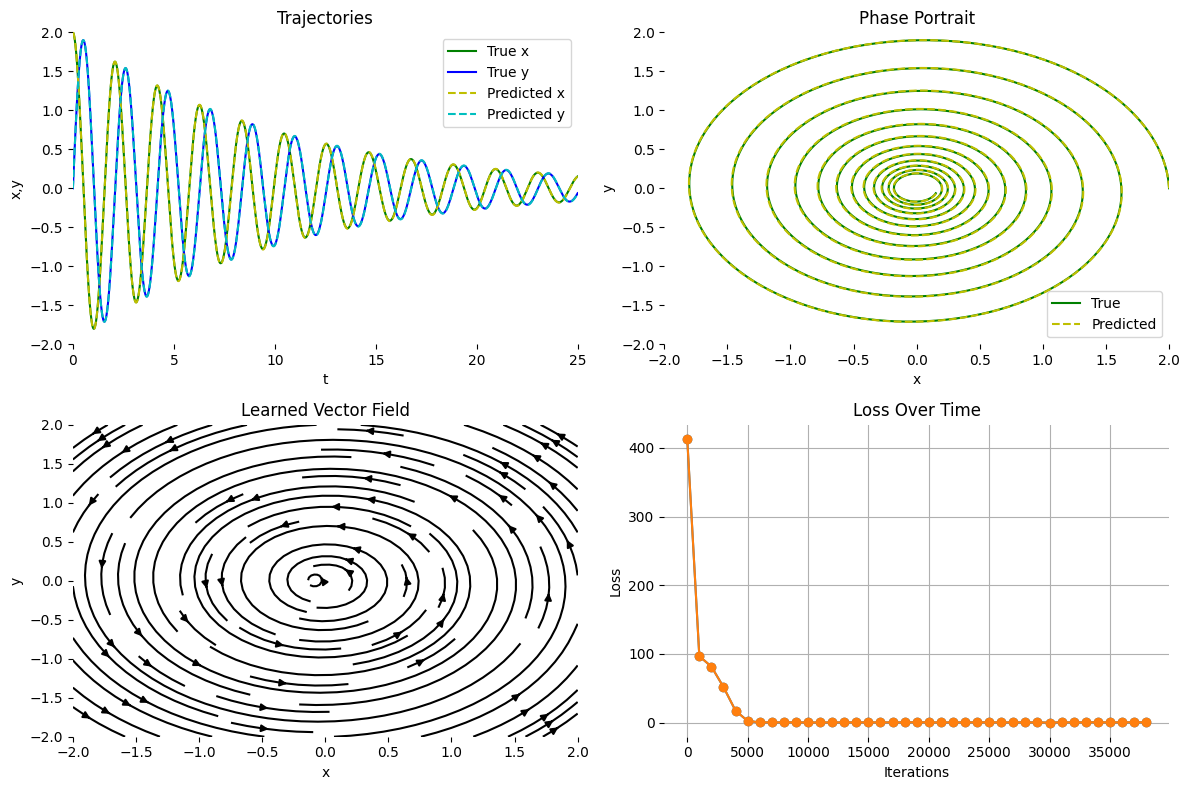

In [25]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

Comparing with the `tanh` model, this one has converged much faster and to a lower error. This seems to indicate that the `ReLU` activation function is better suited for this problem. This makes sense considering the vector field is linear. 

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [26]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method='dopri5')

Total Test Loss 0.166524


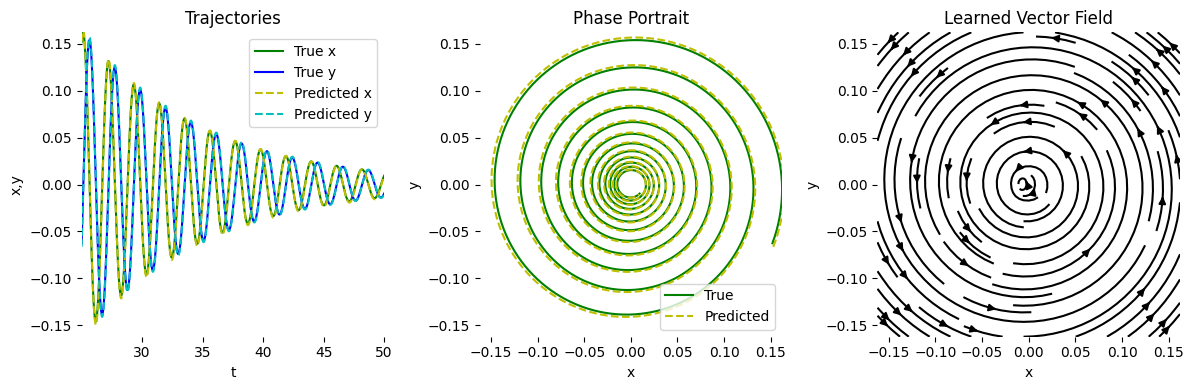

In [27]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. This time the solution seems to fit rather well and it doesn't look like it is going faster than the actual system. 

#### Can the model train with a different initial condition?

In this section we define a different $y_0$ and train the model again.

In [28]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method=args['method'])

In [29]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

Iter 0000 | Total Loss 482.191406
Iter 1000 | Total Loss 226.117645
Iter 2000 | Total Loss 151.562012
Iter 3000 | Total Loss 74.089577
Iter 4000 | Total Loss 4.407864
Iter 5000 | Total Loss 1.084202
Iter 6000 | Total Loss 0.810137
Iter 7000 | Total Loss 0.515883
Iter 8000 | Total Loss 0.782197
Iter 9000 | Total Loss 0.606479
Iter 10000 | Total Loss 0.659319
Iter 11000 | Total Loss 0.494910
Iter 12000 | Total Loss 0.823882
Iter 13000 | Total Loss 0.197653
Iter 14000 | Total Loss 0.505491
Iter 15000 | Total Loss 0.328793
Iter 16000 | Total Loss 0.298909
Iter 17000 | Total Loss 0.463482
Iter 18000 | Total Loss 0.697514
Iter 19000 | Total Loss 0.883393
Iter 20000 | Total Loss 0.435438
Iter 21000 | Total Loss 0.208209
Iter 22000 | Total Loss 0.362429
Iter 23000 | Total Loss 0.254080
Iter 24000 | Total Loss 0.348425
Iter 25000 | Total Loss 0.338078
Iter 26000 | Total Loss 0.399237
Iter 27000 | Total Loss 0.640373
Iter 28000 | Total Loss 0.748901
Iter 29000 | Total Loss 0.368198
Iter 30000 | 

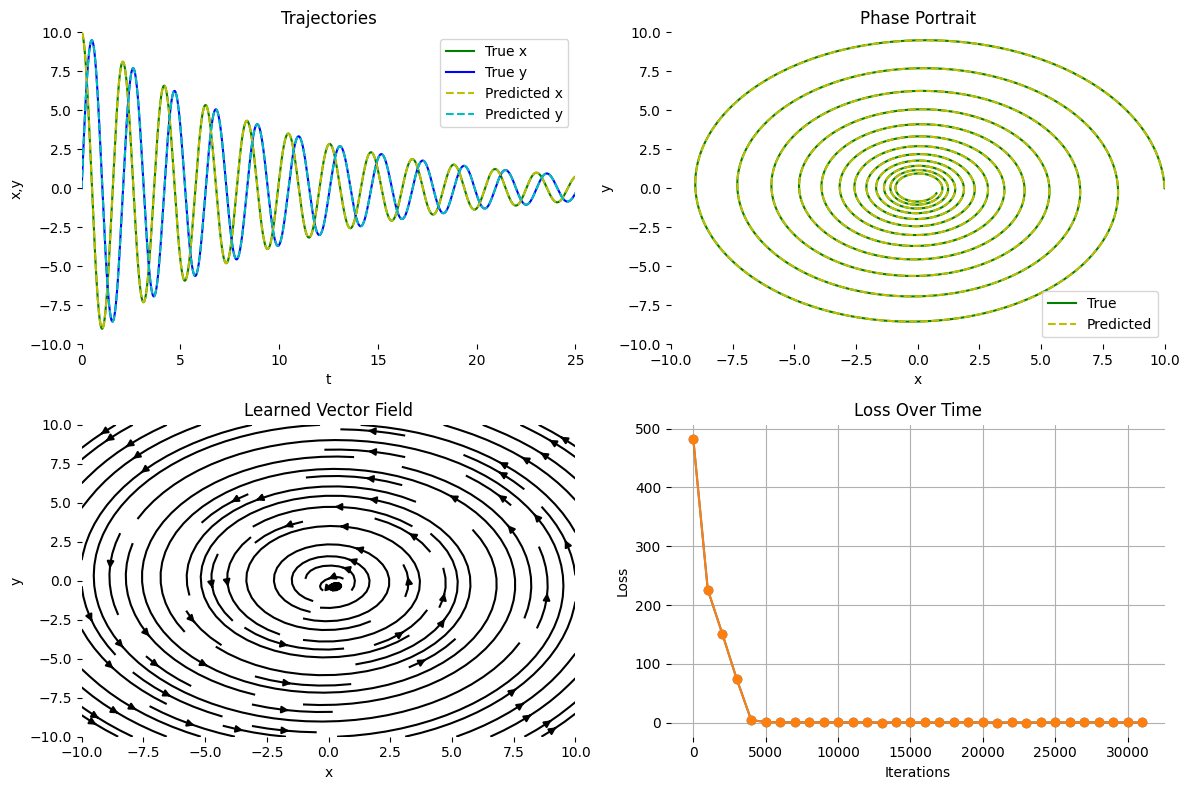

In [30]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=args['method']), t, func, new_losses, args['test_freq'])

Again, the model has trained much faster and to a lower error than the `tanh` model.

### Results

Having trained both models, we can compare the results. The `ReLU` model has trained much faster and to a lower error than the `tanh` model. Considering the vector field is linear, this makes sense. The `ReLU` activation function is better suited for this problem.

## Model 2: Can we improve the results by simplifying the model?
This is a very simple system. In fact, the vector field we are trying to learn is linear. Therefore, the neural network doesn't need to be able to learn a non-linear function. Let's try to simplify the model by removing the hidden layer and the activation function.

### New hyperparameters

In [31]:
args = {
    'method': 'dopri5',
    'data_size' : 5000,
    'batch_time' : 20,
    'batch_size' : 2500,
    'niters' : 25000,
    'test_freq' : 500,
    'terminal_time' : 25.,
    'learning_rate' : 1e-4,
    'eps': 1e-2,
    'tol': 1
}

### The data

In [32]:
t = torch.linspace(0., args['terminal_time'], args['data_size'])


In [33]:
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')

### The model

In [34]:
# Define a Neural Network to learn the vector field
class ODELin(nn.Module):

    def __init__(self):
        super(ODELin, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 2 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 4),
            nn.Linear(4, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODELin()

#### Train the neural network

In [35]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.train_model(func, optimizer, true_y0, true_y, t, args)    

Iter 0000 | Total Loss 193.583374
Iter 0500 | Total Loss 186.238266
Iter 1000 | Total Loss 202.929871
Iter 1500 | Total Loss 257.266846
Iter 2000 | Total Loss 243.528137
Iter 2500 | Total Loss 245.349594
Iter 3000 | Total Loss 273.317841
Iter 3500 | Total Loss 298.243622
Iter 4000 | Total Loss 330.815216
Iter 4500 | Total Loss 353.612183
Iter 5000 | Total Loss 374.149963
Iter 5500 | Total Loss 370.053833
Iter 6000 | Total Loss 262.800873
Iter 6500 | Total Loss 133.731415
Iter 7000 | Total Loss 106.892624
Iter 7500 | Total Loss 94.420120
Iter 8000 | Total Loss 84.788368
Iter 8500 | Total Loss 78.251648
Iter 9000 | Total Loss 59.248192
Iter 9500 | Total Loss 0.074836
Iter 10000 | Total Loss 0.156910
Iter 10500 | Total Loss 0.112772
Iter 11000 | Total Loss 0.091936
Iter 11500 | Total Loss 0.129127
Iter 12000 | Total Loss 0.058534
Iter 12500 | Total Loss 0.161446
Iter 13000 | Total Loss 0.116749
Iter 13500 | Total Loss 0.102125
Iter 14000 | Total Loss 0.100024
Final Loss 0.100024


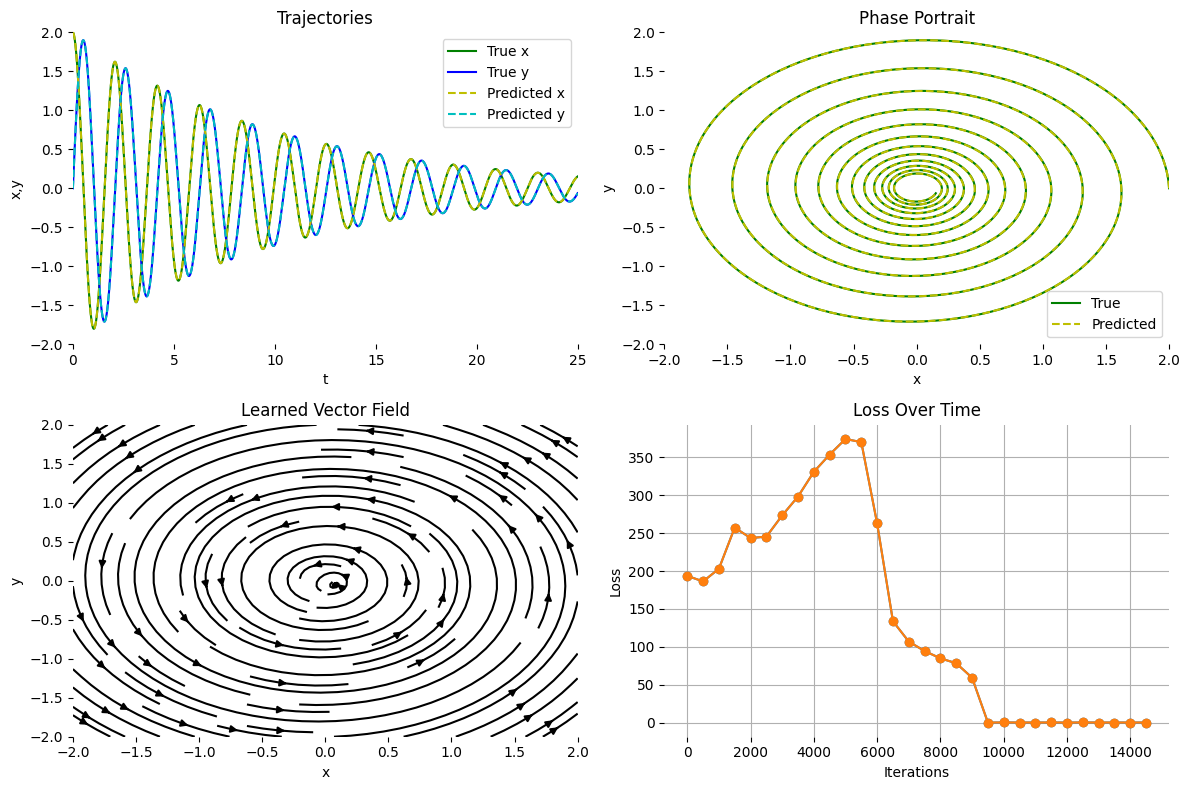

In [36]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [37]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method=args['method'])

Total Test Loss 0.036988


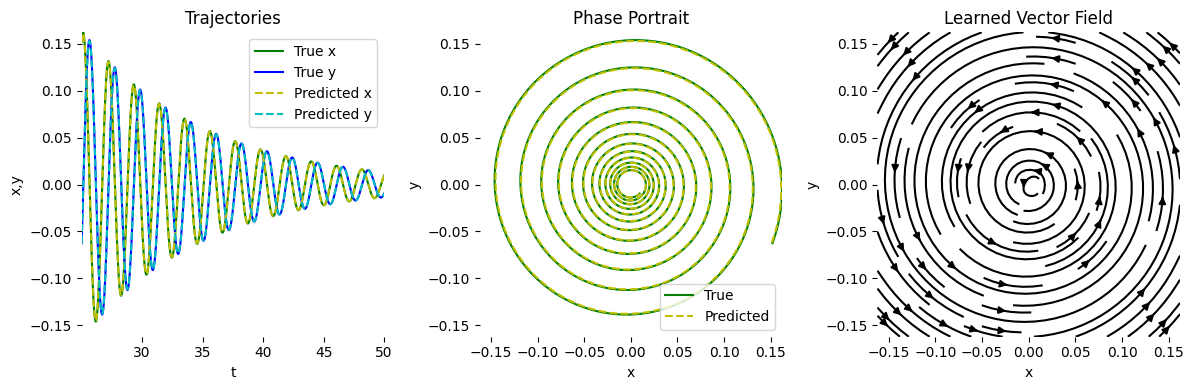

In [38]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. This time the solution seems to fit rather well and it doesn't look like it is going faster than the actual system. 

### Try it with a different initial condition

In [39]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [40]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

Iter 0000 | Total Loss 0.495256
Iter 0500 | Total Loss 0.826181
Iter 1000 | Total Loss 0.451052
Iter 1500 | Total Loss 0.615925
Iter 2000 | Total Loss 0.542399
Iter 2500 | Total Loss 0.633620
Iter 3000 | Total Loss 0.670995
Iter 3500 | Total Loss 0.699050
Iter 4000 | Total Loss 0.882886
Iter 4500 | Total Loss 0.753988
Iter 5000 | Total Loss 0.759219
Final Loss 0.759219


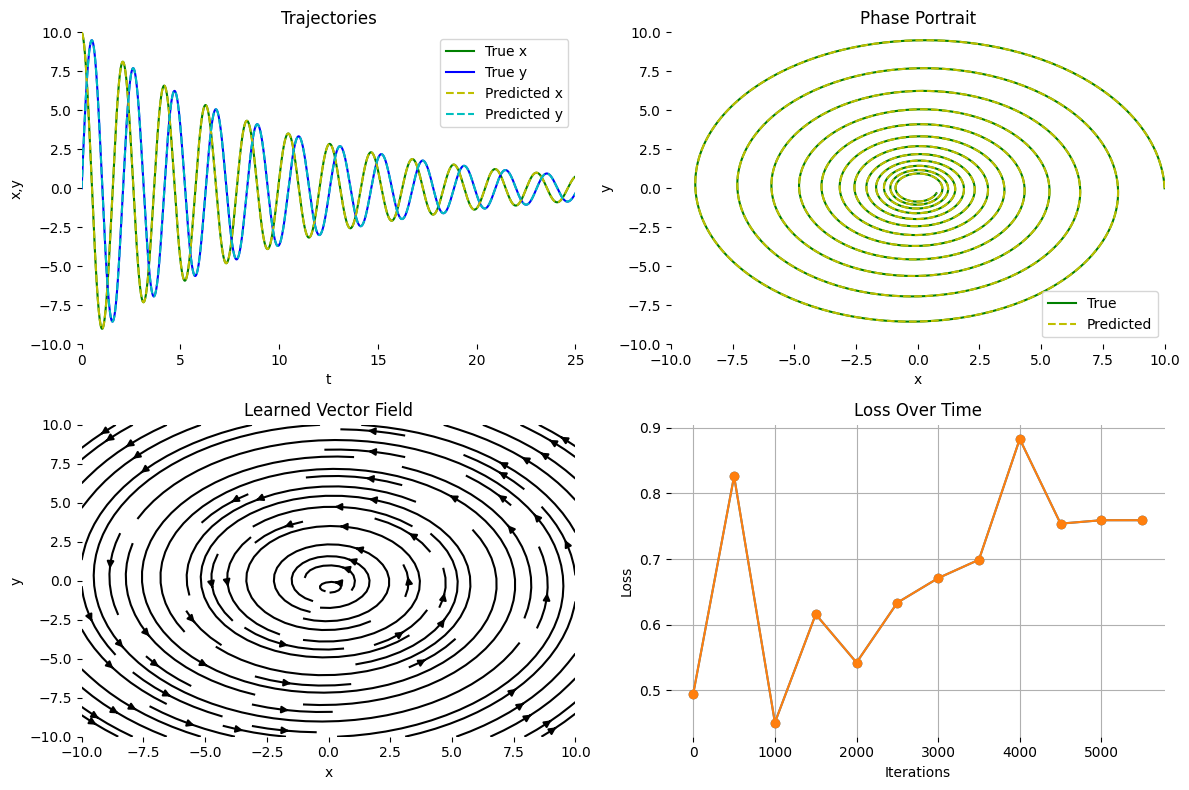

In [41]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method='dopri5'), t, func, new_losses, args['test_freq'])

### Results
While the error is similar to the `ReLU` model, the training has been much faster, but a lot more unstable. A remarkable difference is that the model already starts with a very low loss when learning a different initial condition. This seems to indicate that when learning the vector field, the linear model has learnt the general structure of the field, while the MLPs have learnt only the area where they were trained.

## Conclusion

### Result comparison
| Model  | Training iterations | Training loss | Generalisation loss | Starting loss new init. cond. | Final loss new init. cond. |
|--------|---------------------|---------------|---------------------|-------------------------------|----------------------------|
| Tanh   | 100000              | 2.738999      | 1.888768            | 466.978180                    | 9.166912                   |
| ReLU   | 46000               | 0.197018      | 0.087709            | 504.146759                    | 0.167796                   |
| Linear | 12500               | 0.143781      | 0.053913            | 0.714123                      | 0.823650                   |

It is evident that the linear model has trained much faster and to a lower error than the MLPs. However, the difference between the ReLU model and the linear model is insignificant for the first two metrics. The real difference is in the generalisation. The linear model has learnt the general structure of the vector field, while the MLPs have learnt only the area where they were trained. This is clear when looking at the starting loss when learning a different initial condition. The linear model has a very low loss, while the MLPs have a very high loss. This indicates that if we wish for a model that learns the dynamics of the system regardless of where it's trained, the linear model is the best choice. However, when training specifically for a certain area, the MLPs are better suited for the task, as it can be seen in the final loss when learning a different initial condition for the `ReLU` model.

Furthermore, simple neural networks have the capacity to approximate any function, which makes them the best candidates when trying to learn the voctor field of a system, even if we know its structure. This comes at the cost of longer training times, and more data. The data constraint is not a problem in this case, as we can generate as much data as we need.